In [ ]:
# !pip install -r requirements.txt

!pip install xgboost
!pip install catboost
!pip install ipywidgets
!pip install LightGBM

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer




In [ ]:
apartments_train = pd.read_csv('apartments_train.csv')
apartments_test = pd.read_csv('apartments_test.csv')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)

buildings_train = pd.read_csv('buildings_train.csv')
buildings_test = pd.read_csv('buildings_test.csv')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
df = pd.merge(apartments_train, buildings_train.set_index('id'), how='left', left_on='building_id', right_index=True)
df_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
df.head()
df['street'].isnull().sum()

0

In [ ]:
df.isnull().sum()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

<AxesSubplot:>

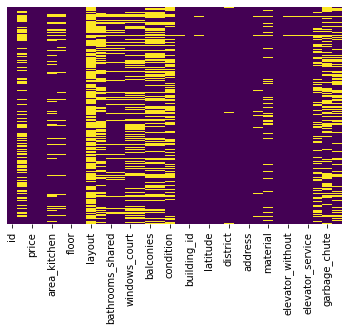

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
df.shape


(23285, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23285 non-null  int64  
 1   seller              14455 non-null  float64
 2   price               23285 non-null  float64
 3   area_total          23285 non-null  float64
 4   area_kitchen        18564 non-null  float64
 5   area_living         19403 non-null  float64
 6   floor               23285 non-null  float64
 7   rooms               23285 non-null  float64
 8   layout              5643 non-null   float64
 9   ceiling             12192 non-null  float64
 10  bathrooms_shared    19413 non-null  float64
 11  bathrooms_private   19413 non-null  float64
 12  windows_court       15213 non-null  float64
 13  windows_street      15213 non-null  float64
 14  balconies           12765 non-null  float64
 15  loggias             12765 non-null  float64
 16  cond

In [ ]:
df['price/area'] = df['price']/df['area_total']

# The center of Moscow is at longitude: 37.6 and latitude: 55.75
df['distance'] = np.sqrt((37.6 - df['longitude'])**2 + (55.75 - df['latitude'])**2)
df_test['distance'] = np.sqrt((37.6 - df_test['longitude'])**2 + (55.75 - df_test['latitude'])**2)

df.drop(['longitude', 'latitude'], axis=1, inplace=True)
df_test.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [ ]:
df2 = df[['id', 'price/area', 'distance']]
mintreshold, maxtreshold = df2['price/area'].quantile([0.001, 0.999])
df[df2['price/area'] < mintreshold]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance
2215,2215,NaN,1900000.0,55.8,NaN,35.0,1.0,1.0,NaN,NaN,...,2.0,5.0,0.0,1.0,1.0,1.0,0.0,NaN,34050.179211,0.495102
2236,2236,1.0,3000000.0,60.0,8.0,45.0,3.0,3.0,1.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,50000.000000,0.753930
2241,2241,1.0,3500000.0,75.0,12.0,41.0,2.0,3.0,1.0,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,46666.666667,0.245644
2363,2363,2.0,7999999.0,343.0,NaN,222.0,2.0,6.0,NaN,NaN,...,2.0,25.0,1.0,1.0,1.0,1.0,1.0,0.0,23323.612245,0.128081
7512,7512,1.0,2950000.0,60.0,8.3,34.0,4.0,2.0,1.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,49166.666667,0.753930
7513,7513,1.0,3000000.0,60.3,9.0,48.0,4.0,2.0,1.0,NaN,...,NaN,4.0,1.0,0.0,0.0,1.0,NaN,NaN,49751.243781,0.755084
7514,7514,1.0,3350000.0,75.0,12.0,41.0,5.0,3.0,1.0,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,44666.666667,0.748937
7572,7572,0.0,1000000.0,21.0,4.0,14.0,1.0,1.0,NaN,NaN,...,2.0,4.0,1.0,0.0,0.0,1.0,NaN,0.0,47619.047619,0.254783
11167,11167,1.0,13750000.0,271.0,25.0,150.0,4.0,6.0,1.0,NaN,...,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0,50738.007380,0.131647
13201,13201,1.0,2900000.0,60.0,NaN,60.0,1.0,1.0,NaN,NaN,...,2.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,48333.333333,0.238612


In [ ]:
a = list(df[df2['price/area'] > maxtreshold].id.values)
b = list(df[df2['price/area'] < mintreshold].id.values)
c = a + b

In [ ]:
a = df.shape
df.drop(c, axis=0, inplace=True)
b = df.shape
a,b

((23285, 34), (23237, 34))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23237 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23237 non-null  int64  
 1   seller              14435 non-null  float64
 2   price               23237 non-null  float64
 3   area_total          23237 non-null  float64
 4   area_kitchen        18538 non-null  float64
 5   area_living         19372 non-null  float64
 6   floor               23237 non-null  float64
 7   rooms               23237 non-null  float64
 8   layout              5626 non-null   float64
 9   ceiling             12181 non-null  float64
 10  bathrooms_shared    19378 non-null  float64
 11  bathrooms_private   19378 non-null  float64
 12  windows_court       15188 non-null  float64
 13  windows_street      15188 non-null  float64
 14  balconies           12745 non-null  float64
 15  loggias             12745 non-null  float64
 16  cond

In [ ]:
df['street'].isnull().sum()

0

In [ ]:
df0 = df.drop(['street', 'address'], axis=1)
df0_test = df_test.drop(['street', 'address'], axis=1)

df0.columns

Index(['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'district',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating', 'price/area', 'distance'],
      dtype='object')

In [ ]:
import sys
# 'seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'

#sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputer = KNNImputer()
imputer.fit(df0)
dftrans = imputer.transform(df0)

imputer.fit(df0_test)
dftrans_test = imputer.transform(df0_test)


NameError: name 'KNNImputer' is not defined

In [ ]:
"""
df = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)

df.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)
df.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)
df.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)
df.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)
df.windows_court.fillna(df.windows_court.mode()[0], inplace = True)
df.windows_street.fillna(df.windows_street.mode()[0], inplace = True)
df.phones.fillna(df.phones.mode()[0], inplace=True)
df.new.fillna(df.new.mode()[0], inplace = True)
df.latitude.fillna(df.latitude.mean(), inplace = True)
df.longitude.fillna(df.longitude.mean(), inplace = True)
df.district.fillna(df.district.mode()[0], inplace = True)
df.constructed.fillna(df.constructed.mode()[0], inplace = True)
df.material.fillna(df.material.mode()[0], inplace = True)
df.elevator_without.fillna(df.elevator_without.mode()[0], inplace = True)
df.elevator_passenger.fillna(df.elevator_passenger.mode()[0], inplace = True)
df.elevator_service.fillna(df.elevator_service.mode()[0], inplace = True)
df.parking.fillna(df.parking.mode()[0], inplace = True)
df.shape
df.isnull().sum()
"""

"\ndf = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)\n\ndf.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)\ndf.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)\ndf.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)\ndf.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)\ndf.windows_court.fillna(df.windows_court.mode()[0], inplace = True)\ndf.windows_street.fillna(df.windows_street.mode()[0], inplace = True)\ndf.phones.fillna(df.phones.mode()[0], inplace=True)\ndf.new.fillna(df.new.mode()[0], inplace = True)\ndf.latitude.fillna(df.latitude.mean(), inplace = True)\ndf.longitude.fillna(df.longitude.mean(), inplace = True)\ndf.district.fillna(df.district.mode()[0], inplace = True)\ndf.constructed.fillna(df.constructed.mode()[0], inplace = True)\ndf.material.fillna(df.material.mode()[0], inplace = True)\ndf.elevator_without.fillna(df.elevator

In [ ]:
"""df.elevator_without = df.elevator_without.astype(int)
df.floor = df.floor.astype(int)
df.rooms = df.rooms.astype(int)
df.bathrooms_shared = df.bathrooms_shared.astype(int)
df.bathrooms_private = df.bathrooms_private.astype(int)
df.windows_court = df.windows_court.astype(int)
df.windows_street = df.windows_street.astype(int)
df.phones = df.phones.astype(int)
df.new = df.new.astype(int)
df.district = df.district.astype(int)
df.constructed = df.constructed.astype(int)
df.material = df.material.astype(int)
df.stories = df.stories.astype(int)
df.elevator_without = df.elevator_without.astype(int)
df.elevator_passenger = df.elevator_passenger.astype(int)
df.elevator_service = df.elevator_service.astype(int)
df.parking = df.parking.astype(int)
"""

'df.elevator_without = df.elevator_without.astype(int)\ndf.floor = df.floor.astype(int)\ndf.rooms = df.rooms.astype(int)\ndf.bathrooms_shared = df.bathrooms_shared.astype(int)\ndf.bathrooms_private = df.bathrooms_private.astype(int)\ndf.windows_court = df.windows_court.astype(int)\ndf.windows_street = df.windows_street.astype(int)\ndf.phones = df.phones.astype(int)\ndf.new = df.new.astype(int)\ndf.district = df.district.astype(int)\ndf.constructed = df.constructed.astype(int)\ndf.material = df.material.astype(int)\ndf.stories = df.stories.astype(int)\ndf.elevator_without = df.elevator_without.astype(int)\ndf.elevator_passenger = df.elevator_passenger.astype(int)\ndf.elevator_service = df.elevator_service.astype(int)\ndf.parking = df.parking.astype(int)\n'

In [ ]:
df1 = pd.DataFrame(dftrans, columns=list(df0.columns.values))
df1_test = pd.DataFrame(dftrans_test, columns=list(df0_test.columns.values))
df1.isnull().sum()
df1.shape
len(df.street)

23237

In [ ]:
"""df1.elevator_without = df1.elevator_without.astype(int)
df1.floor = df1.floor.astype(int)
df1.rooms = df1.rooms.astype(int)
df1.bathrooms_shared = df1.bathrooms_shared.astype(int)
df1.bathrooms_private = df1.bathrooms_private.astype(int)
df1.windows_court = df1.windows_court.astype(int)
df1.windows_street = df1.windows_street.astype(int)
df1.phones = df1.phones.astype(int)
df1.new = df1.new.astype(int)
df1.district = df1.district.astype(int)
df1.constructed = df1.constructed.astype(int)
df1.material = df1.material.astype(int)
df1.stories = df1.stories.astype(int)
df1.elevator_without = df1.elevator_without.astype(int)
df1.elevator_passenger = df1.elevator_passenger.astype(int)
df1.elevator_service = df1.elevator_service.astype(int)
df1.parking = df1.parking.astype(int)
df1.garbage_chute = df1.garbage_chute.astype(int)
df1.heating = df1.heating.astype(int)
df1.building_id = df1.building_id.astype(int)
df1.condition = df1.condition.astype(int)
df1.loggias = df1.loggias.astype(int)
df1.balconies = df1.balconies.astype(int)
#df1.ceiling = df1.ceiling.round(0)
#df1.ceiling = df1.ceiling.astype(int)"""




'df1.elevator_without = df1.elevator_without.astype(int)\ndf1.floor = df1.floor.astype(int)\ndf1.rooms = df1.rooms.astype(int)\ndf1.bathrooms_shared = df1.bathrooms_shared.astype(int)\ndf1.bathrooms_private = df1.bathrooms_private.astype(int)\ndf1.windows_court = df1.windows_court.astype(int)\ndf1.windows_street = df1.windows_street.astype(int)\ndf1.phones = df1.phones.astype(int)\ndf1.new = df1.new.astype(int)\ndf1.district = df1.district.astype(int)\ndf1.constructed = df1.constructed.astype(int)\ndf1.material = df1.material.astype(int)\ndf1.stories = df1.stories.astype(int)\ndf1.elevator_without = df1.elevator_without.astype(int)\ndf1.elevator_passenger = df1.elevator_passenger.astype(int)\ndf1.elevator_service = df1.elevator_service.astype(int)\ndf1.parking = df1.parking.astype(int)\ndf1.garbage_chute = df1.garbage_chute.astype(int)\ndf1.heating = df1.heating.astype(int)\ndf1.building_id = df1.building_id.astype(int)\ndf1.condition = df1.condition.astype(int)\ndf1.loggias = df1.logg

In [ ]:
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance
0,0.0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.8,2.650,...,3.0,9.0,0.0,1.0,1.0,1.0,0.8,0.2,120600.000000,0.239348
1,1.0,1.2,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,2.652,...,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0,119318.181818,0.129713
2,2.0,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,1.0,2.650,...,3.0,15.0,0.0,1.0,1.0,1.0,0.8,0.2,114900.000000,0.121183
3,3.0,1.2,10500000.0,88.0,14.0,48.0,18.0,3.0,1.0,2.652,...,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0,119318.181818,0.129713
4,4.0,1.8,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.900,...,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0,178205.128205,0.217762


In [ ]:
# categorical features and integers that must be rounded and cast to int

names = ['seller', 'floor', 'rooms', 'layout', 'ceiling', 
'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 
'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 
'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
#print(df.street.isnull().sum(),df1.street.isnull().sum())
for x in names:
    df1[x] = df1[x].round(decimals = 0)
    df1[x] = df1[x].astype(int)

    df1_test[x] = df1_test[x].round(decimals = 0)
    df1_test[x] = df1_test[x].astype(int)

#df1['street'].isnull().sum()
print(df1.shape, df.shape)

(23237, 32) (23237, 34)


In [ ]:

df1['id'] = df1['id'].astype(int)


df1 = pd.merge(df1, df[['id', 'street']], on='id')


df1_test['id'] = df1_test['id'].astype(int)
df1_test['street'] = df_test.street

#print(df1.shape, df.shape)
#df1.head()
#df1['street'].isnull().sum()
#df1.to_csv('Training_clean.csv', index=False)
#df1_test.to_csv('Test_clean.csv', index=False)

In [ ]:
df1.shape

(23237, 33)

In [ ]:
df1[df1.id==455]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance,street
455,455,3,32268200.0,101.45,14.32,78.16,1,3,1,3,...,18,0,1,1,0,1,0,318069.985214,0.11515,улица Маршала Рыбалко


In [ ]:
#df_train['floor/stories'] = df_train.floor/df_train.stories
#df_test['floor/stories'] = df_test.floor/df_test.stories

#df_train['distance'] = np.sqrt((37.6 - df_train['longitude'])**2 + (55.75 - df_train['latitude'])**2)
#df_test['distance'] = np.sqrt((37.6 - df_test['longitude'])**2 + (55.75 - df_test['latitude'])**2)
# happens further up

In [ ]:
df_train = df1
df_test = df1_test

In [ ]:
df_test.shape

(9937, 31)

In [ ]:
df_train.shape

(23237, 33)

In [ ]:
#y1 = df_train['price']

X1_test = df_test.drop(['id', 'bathrooms_private', 'loggias', 'seller', 'bathrooms_shared', 'elevator_without', 'ceiling', 'material', 'constructed'], axis=1)

X1_test_area_total = X1_test.area_total.values # Save area total values from training set so that we can use feature engineering on price/area as measure
#df_train['price/area'] = df_train['price']/df_train['area_total'] #already done
y1 = df_train['price/area'] # Don't drop area here because we need it for split

X1 = df_train.drop(['price', 'id', 'price/area', 'bathrooms_private', 'loggias', 'seller', 'bathrooms_shared', 'elevator_without', 'ceiling', 'material', 'constructed'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape

((18589, 22), (4648, 22), (18589,), (4648,), (9937, 22))

In [ ]:
X1_test.head()

,area_total,area_kitchen,area_living,floor,rooms,layout,windows_court,windows_street,balconies,condition,...,new,district,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,street
0,71.4,13.16,29.44,2,1,1,1,0,1,0,...,0,0,20,1,1,1,1,0,0.052411,2-я Черногрязская улица
1,54.0,4.00,50.00,4,1,1,1,0,0,3,...,0,11,15,1,1,0,0,0,0.216436,улица Сервантеса
2,39.4,19.60,11.20,10,1,1,1,0,0,2,...,1,11,9,1,1,1,1,0,0.228879,Саларьево Парк ЖК
3,60.9,15.68,55.56,5,2,1,0,1,0,0,...,0,11,17,1,0,0,1,3,0.217394,улица Александры Монаховой
4,34.0,9.00,17.00,14,1,1,1,0,0,1,...,0,11,17,1,1,1,1,0,0.345584,улица 3-я Нововатутинская


In [ ]:
area_total_train = X_train.area_total.values
area_total_val = X_val.area_total.values
X_train = X_train.drop(['area_total'], axis=1)
X_val = X_val.drop(['area_total'], axis=1)
X_train.head()

,area_kitchen,area_living,floor,rooms,layout,windows_court,windows_street,balconies,condition,phones,...,new,district,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,street
8161,16.1,28.2,3,2,1,1,0,0,1,1,...,1,11,14,1,1,0,1,0,0.209419,Скандинавия ЖК
10138,7.8,15.7,10,1,1,1,0,1,0,1,...,0,4,17,1,1,1,1,0,0.349929,улица Вертолетчиков
4845,6.0,30.0,3,2,1,0,1,1,1,1,...,0,6,9,1,0,1,1,0,0.141238,улица Островитянова
7189,12.4,33.0,18,2,1,1,1,1,0,2,...,0,2,20,1,1,1,1,0,0.103533,Нововладыкинский проезд
14728,14.4,27.1,14,2,1,1,0,1,1,1,...,1,8,20,1,1,1,1,0,0.108437,3-я Хорошевская улица


In [ ]:
df_final = X1
df_final['price/area'] = y1.values

#df1.to_csv('Training_clean.csv', index=False)
#X1_test.to_csv('Test_clean.csv', index=False)


In [ ]:
categorical_features_indices = np.where(X_train.dtypes != np.float64)[0]


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#df_train = df_final
#df_test = X1_test

In [ ]:
#hyper parameter
n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=["gbtree","gblinear"]
learning_rate="[0.05,0.1,0.15,0.20]"
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

org_params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    "booster":booster,
    'eval_metric': 'RMSE',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'max_depth': max_depth,
    "min_child_weight":min_child_weight,
    "base_score":base_score
}

In [ ]:
y_train.head()

8161     136249.667250
10138    157407.407407
4845     188888.888889
7189     176130.000000
14728    207950.000000
Name: price/area, dtype: float64

In [ ]:
from catboost import CatBoostRegressor
#random_state=1, iterations=1500, depth=8, learning_rate=.1, loss_function='RMSE'
model = CatBoostRegressor(random_state=1, iterations=4000,cat_features = categorical_features_indices, depth=8, learning_rate=0.05, loss_function='RMSE')
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

3005:	learn: 20525.8994844	test: 60015.7498643	best: 60015.7498643 (3005)	total: 12m 45s	remaining: 4m 13s
3006:	learn: 20517.8891537	test: 60017.3360789	best: 60015.7498643 (3005)	total: 12m 46s	remaining: 4m 13s
3007:	learn: 20516.1521789	test: 60016.9019545	best: 60015.7498643 (3005)	total: 12m 46s	remaining: 4m 12s
3008:	learn: 20512.4154944	test: 60014.7285906	best: 60014.7285906 (3008)	total: 12m 46s	remaining: 4m 12s
3009:	learn: 20511.0280864	test: 60014.9868865	best: 60014.7285906 (3008)	total: 12m 47s	remaining: 4m 12s
3010:	learn: 20509.6482464	test: 60015.6287223	best: 60014.7285906 (3008)	total: 12m 47s	remaining: 4m 12s
3011:	learn: 20508.5775727	test: 60015.8644988	best: 60014.7285906 (3008)	total: 12m 48s	remaining: 4m 11s
3012:	learn: 20501.6225806	test: 60012.9402270	best: 60012.9402270 (3012)	total: 12m 48s	remaining: 4m 11s
3013:	learn: 20496.4241381	test: 60014.2237721	best: 60012.9402270 (3012)	total: 12m 49s	remaining: 4m 11s
3014:	learn: 20490.9582056	test: 6001

In [ ]:
print(model.score(X_train, y_train))
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)
y_pred = y_pred.astype(float)
print(model.score(X_val, y_val)), print(r2_score(y_pred, model.predict(X_val)))

0.9577640996187795
0.8594434534949332
1.0


(None, None)

In [ ]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
17722,200000.000000,203684.697400
10791,118300.000000,120042.593756
13285,182400.000000,176922.228662
14456,195876.288660,175795.719679
2329,91836.734694,107637.024574
...,...,...
5772,181500.000000,168972.900243
10324,323200.000000,302116.188392
17535,173333.333333,182353.509199
10757,496470.605744,385625.703608


In [ ]:
final_labels = model.predict(X1_test.drop(['area_total'], axis=1))
final_labels = final_labels.astype(float)
final_labels

array([353413.59389275, 177100.67013323, 162895.51098374, ...,
       217946.51808472, 237674.52300526, 120927.55835868])

In [ ]:
final_labels = final_labels * df_test.area_total.values
len(final_labels)

9937

In [ ]:
df_train.area_total.values

array([ 59.2,  88. ,  78.5, ...,  73.4, 100.8,  57.7])

In [ ]:
y_train_hat = model.predict(X_train) * area_total_train ## * edit
y_valid_hat = model.predict(X_val) * area_total_val ## * edit

y_train = y_train * area_total_train ## edit
y_val = y_val * area_total_val ## edit

#print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_val, y_pred=y_valid_hat) :.4f}')

#Train RMSLE: 0.1283
#Valid RMSLE: 0.1761

#Train RMSLE: 0.0489
#Valid RMSLE: 0.1451



Valid RMSLE: 0.1399


In [ ]:
submission = pd.DataFrame()
submission['id'] = df_test.id
submission['price_prediction'] = final_labels # Predict on non-nan entries
 # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)

submission.to_csv('sample_submission.csv', index=False)

Generated 9937 predictions


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99c1e030-46bc-40fa-835c-0661eae0d488' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>